In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        )
    
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
    
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [11]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [12]:
gen = Generator()
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(10, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

In [13]:
num_test = 100

test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_noise.shape

torch.Size([100, 10])

In [15]:
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
test_uns_noise.shape

torch.Size([100, 10, 1, 1])

In [22]:
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
hidden_output = test_hidden_block(test_uns_noise)
hidden_output.shape

torch.Size([100, 20, 4, 4])

In [23]:
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)
test_hidden_block_stride(hidden_output).shape

torch.Size([100, 20, 10, 10])

In [30]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim *  2, 1, final_layer=True)
        )
    
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
    
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [32]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))
print(test_images.shape)

test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)
print(hidden_output.shape)

test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)
print(final_output.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 5, 8, 8])
torch.Size([100, 10, 6, 6])


In [33]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

In [34]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [37]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [38]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.9482796145677574, discriminator loss: 0.5045884738564493


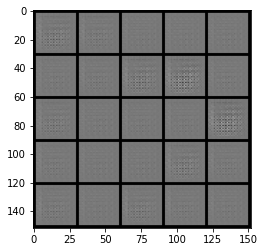

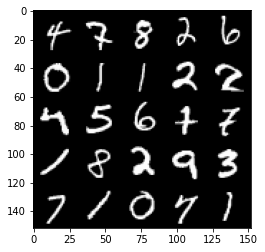

Step 1000: Generator loss: 2.335196813881395, discriminator loss: 0.15969335702806706


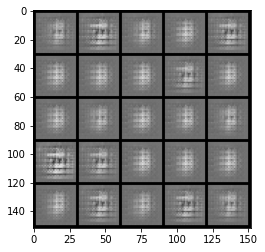

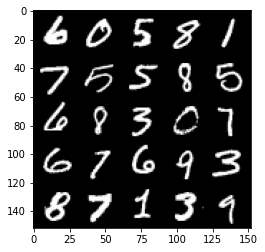

Step 1500: Generator loss: 1.7220242811143387, discriminator loss: 0.38236813476681697


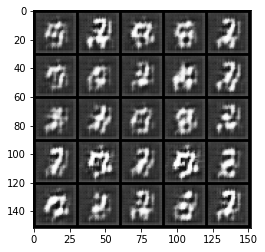

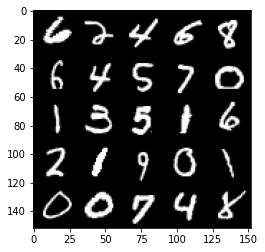

Step 2000: Generator loss: 1.2002982503771775, discriminator loss: 0.5000051406621934


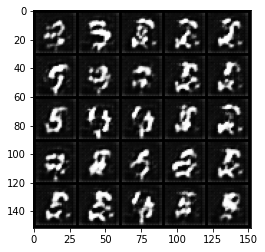

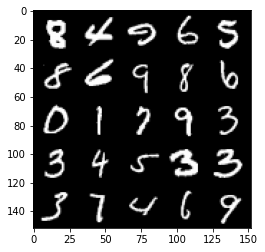

Step 2500: Generator loss: 0.9849220898151402, discriminator loss: 0.5656529709100724


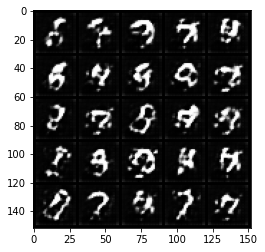

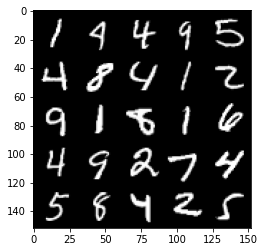

Step 3000: Generator loss: 0.9061703742742543, discriminator loss: 0.5975252023935314


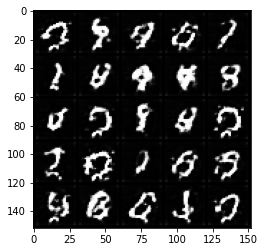

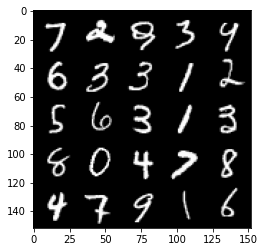

Step 3500: Generator loss: 0.8418723959326746, discriminator loss: 0.6296057379245761


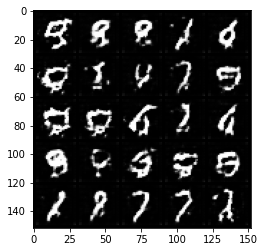

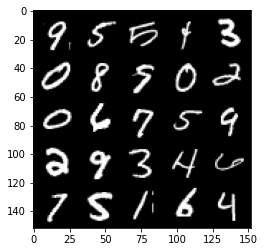

Step 4000: Generator loss: 0.8174318186044695, discriminator loss: 0.6354783904552457


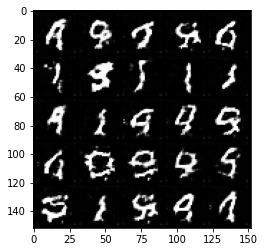

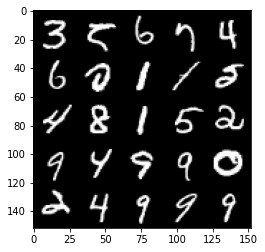

Step 4500: Generator loss: 0.8100508068799971, discriminator loss: 0.6468306815624237


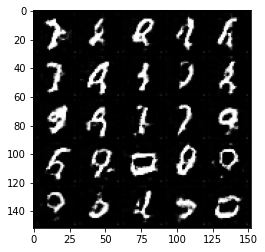

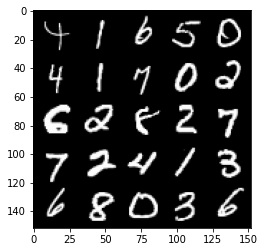

Step 5000: Generator loss: 0.7972442873716362, discriminator loss: 0.6502871985435476


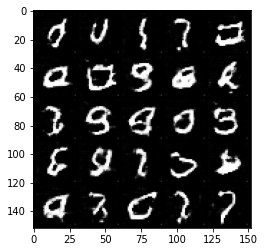

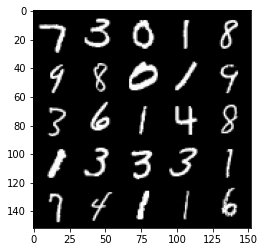

Step 5500: Generator loss: 0.7970661659240716, discriminator loss: 0.6532313967943189


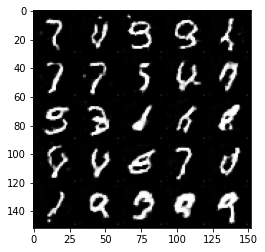

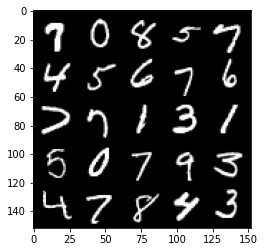

Step 6000: Generator loss: 0.7878724964857099, discriminator loss: 0.6564707872867583


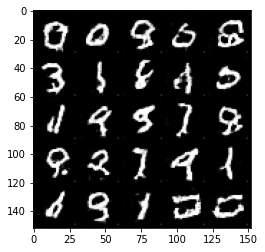

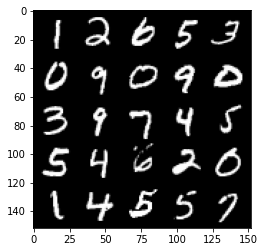

Step 6500: Generator loss: 0.7768941594958307, discriminator loss: 0.664297531127929


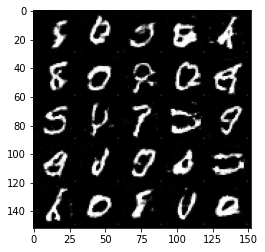

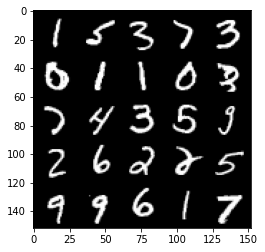

Step 7000: Generator loss: 0.7665534121990204, discriminator loss: 0.6709036539793007


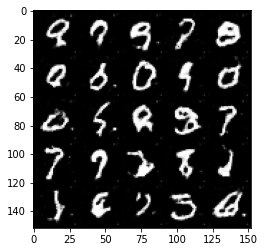

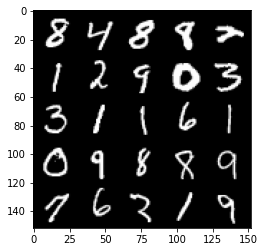

Step 7500: Generator loss: 0.7601885720491414, discriminator loss: 0.6751650102138512


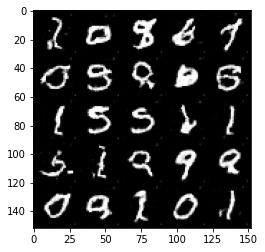

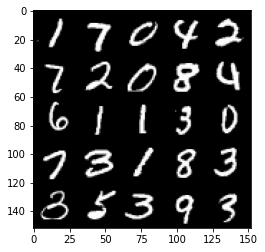

Step 8000: Generator loss: 0.7543260005116462, discriminator loss: 0.6778996102809907


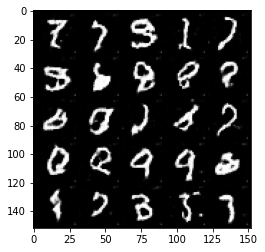

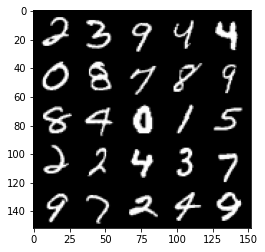

Step 8500: Generator loss: 0.7491991207897665, discriminator loss: 0.6823326300382622


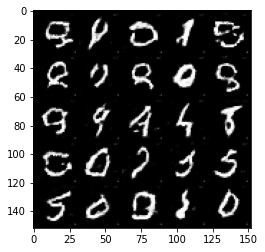

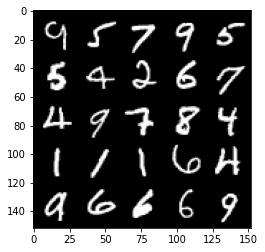

Step 9000: Generator loss: 0.748376731336117, discriminator loss: 0.6847449464797966


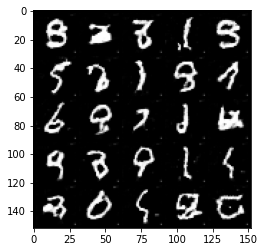

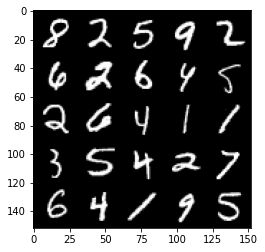

Step 9500: Generator loss: 0.7359932605624192, discriminator loss: 0.6883503338098524


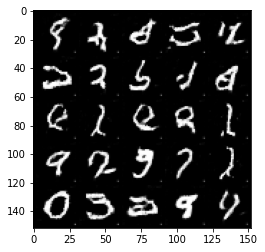

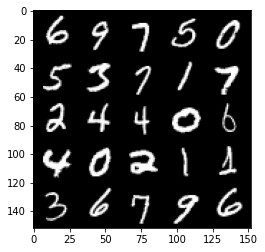

Step 10000: Generator loss: 0.7353377459049217, discriminator loss: 0.6899755011796957


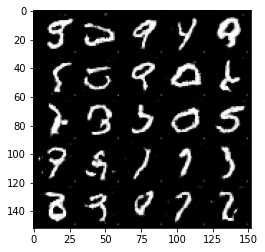

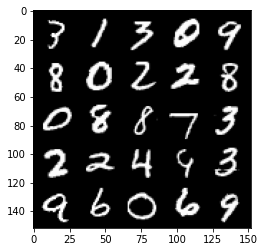

Step 10500: Generator loss: 0.7259443766176696, discriminator loss: 0.6929478467702869


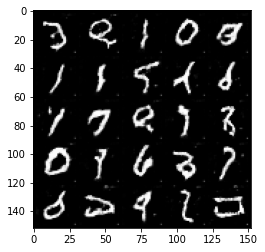

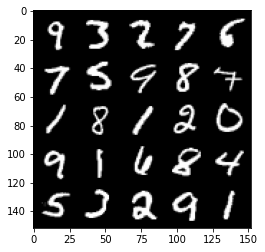

Step 11000: Generator loss: 0.7265323488116265, discriminator loss: 0.6942137339115138


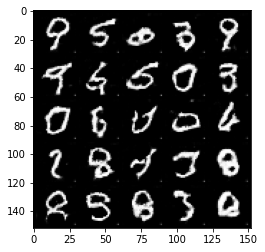

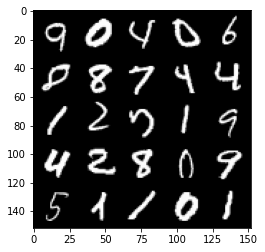

Step 11500: Generator loss: 0.719026669263839, discriminator loss: 0.6946964087486269


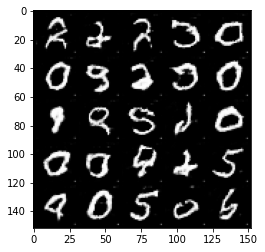

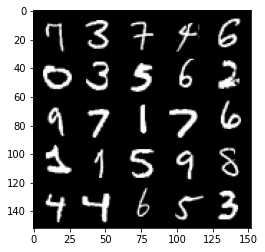

Step 12000: Generator loss: 0.7099031581282609, discriminator loss: 0.7025508809089657


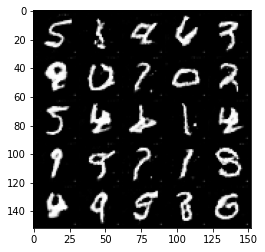

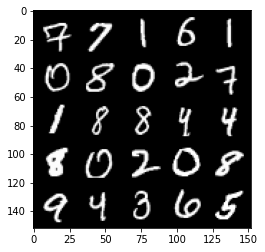

Step 12500: Generator loss: 0.7052370350956918, discriminator loss: 0.6991495772600178


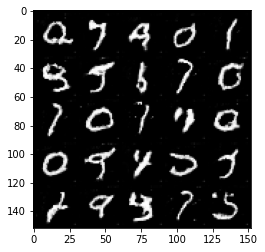

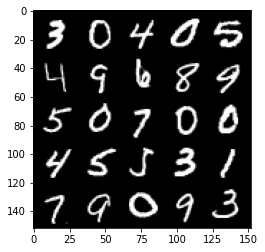

Step 13000: Generator loss: 0.707635080754757, discriminator loss: 0.6980710098743432


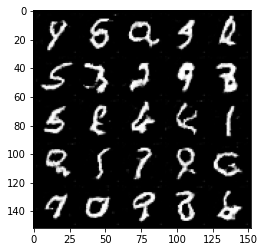

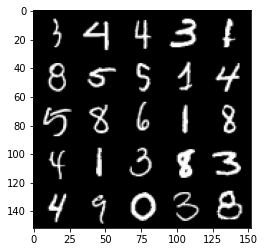

Step 13500: Generator loss: 0.7064856333136558, discriminator loss: 0.6974580645561214


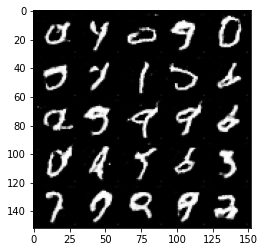

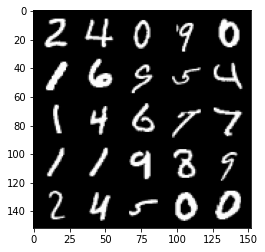

Step 14000: Generator loss: 0.7126717896461486, discriminator loss: 0.6987127919197081


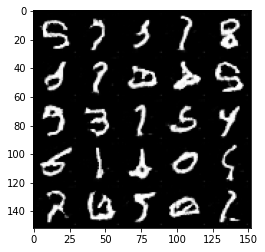

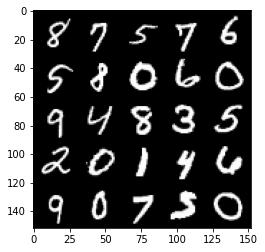

Step 14500: Generator loss: 0.7104646555185316, discriminator loss: 0.6975223783254623


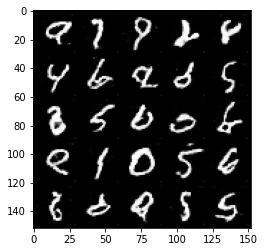

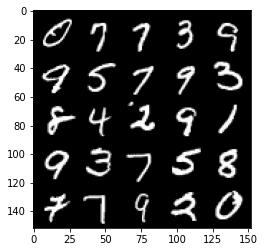

Step 15000: Generator loss: 0.7065322545766831, discriminator loss: 0.6988431651592253


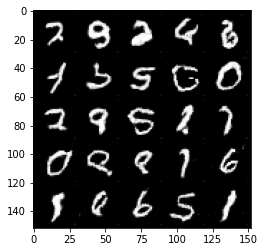

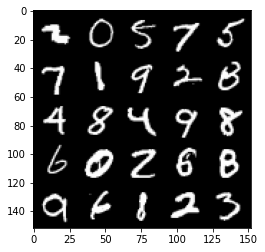

Step 15500: Generator loss: 0.702892515897751, discriminator loss: 0.6982473635673527


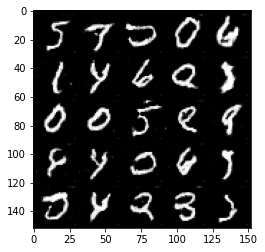

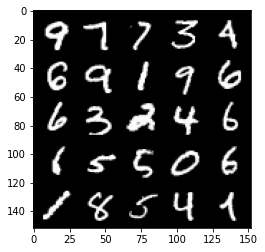

Step 16000: Generator loss: 0.7062000615596772, discriminator loss: 0.6975455266237255


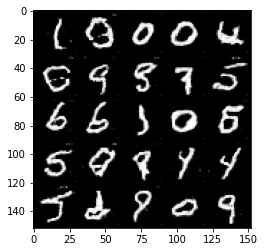

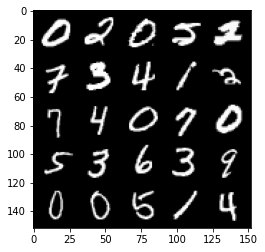

Step 16500: Generator loss: 0.7063476710915567, discriminator loss: 0.6966577209234248


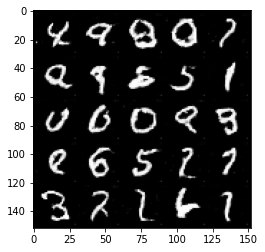

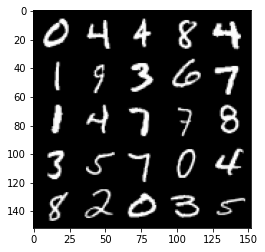

Step 17000: Generator loss: 0.7047072968482971, discriminator loss: 0.6975060441493992


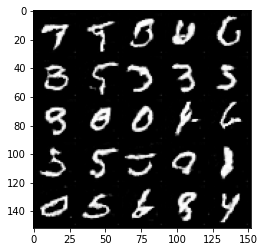

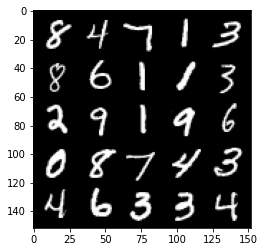

Step 17500: Generator loss: 0.7059528453350068, discriminator loss: 0.696759392857552


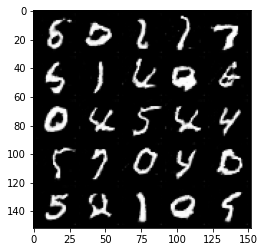

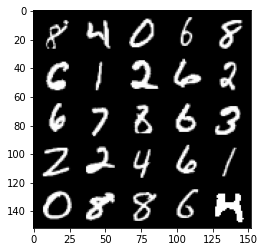

Step 18000: Generator loss: 0.7067655376195913, discriminator loss: 0.6959294047355653


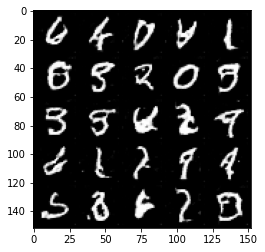

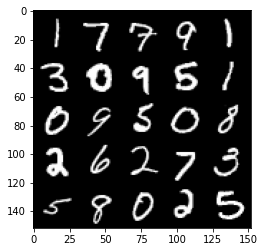

Step 18500: Generator loss: 0.7056324303150178, discriminator loss: 0.6954972294569022


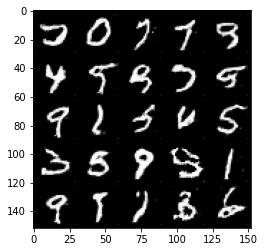

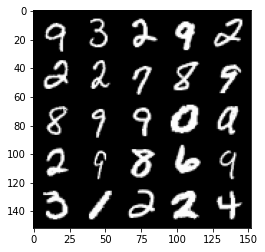

Step 19000: Generator loss: 0.70237685239315, discriminator loss: 0.6967942481040957


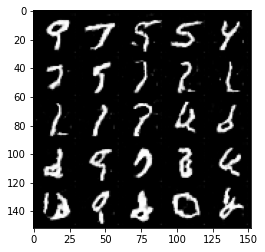

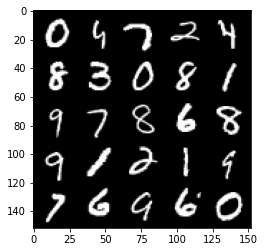

Step 19500: Generator loss: 0.706122965216636, discriminator loss: 0.6959052380323411


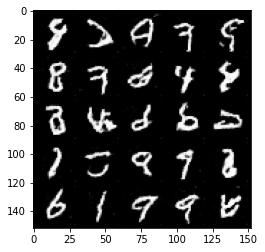

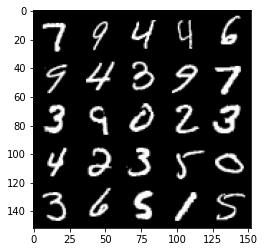

Step 20000: Generator loss: 0.7035057286024092, discriminator loss: 0.695213099956512


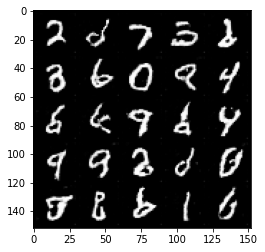

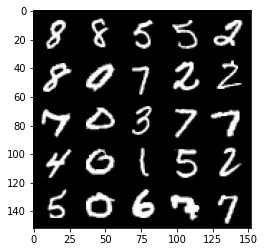

Step 20500: Generator loss: 0.7041493215560909, discriminator loss: 0.6956866883039478


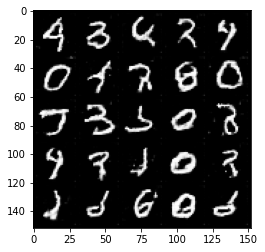

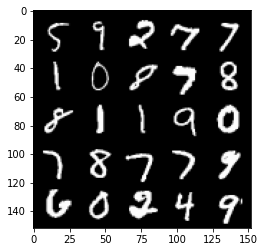

Step 21000: Generator loss: 0.701156608343124, discriminator loss: 0.6954213943481448


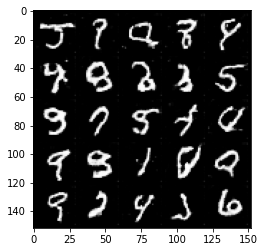

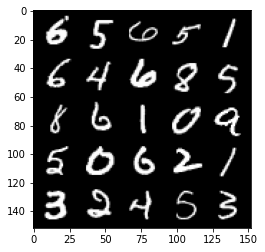

Step 21500: Generator loss: 0.7001588426232332, discriminator loss: 0.6964636702537533


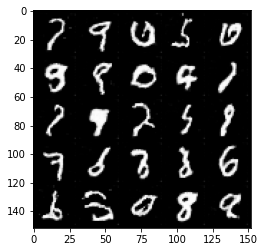

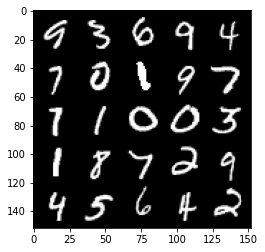

Step 22000: Generator loss: 0.7014888060092928, discriminator loss: 0.6954644894599914


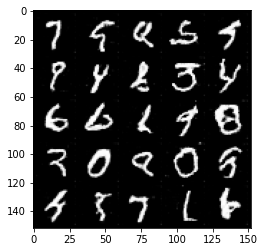

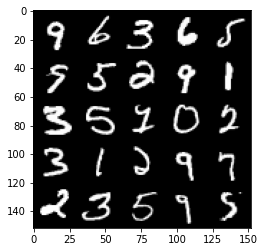

Step 22500: Generator loss: 0.7029493794441224, discriminator loss: 0.6949463353157045


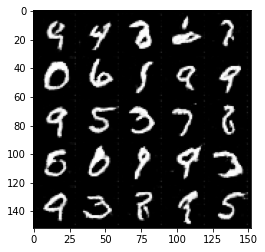

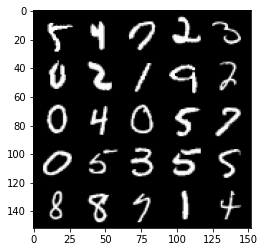

Step 23000: Generator loss: 0.7015786236524579, discriminator loss: 0.6948534065484999


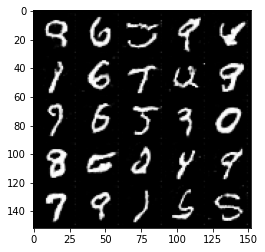

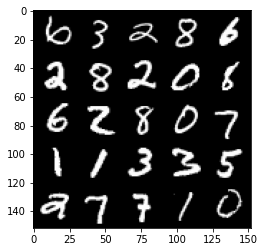

In [39]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        # Update discriminator
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_fake_pred))
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        mean_generator_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1